# 0. Linear Classification Theory

The basis for data classification, and thus making decisions about the sample's class membership, can be the division of the feature space using surfaces that determine the boundaries of regions assigned to objects of different classes. These regions are called <font color=blue>decision regions</font> (ang. <font color=red>decision regions</font>), and the surfaces separating these regions are called <font color=blue>decision boundaries</font> (ang. <font color=red>decision boundary</font>).

If the decision boundaries are parametric, an attempt can be made to algorithmize their determination based on labeled sample datasets, so that they correctly define areas specific to a given class.
The simplest family of parametric surfaces are hyperplanes, i.e., linear surfaces. The simplest criterion for evaluating the quality of space division is a criterion based on assessing the average distance of samples from different classes to their expected positions, expressed by the mean squared error (MSE).

The simplest case of classification is a binary (two-class) problem. The presented geometric interpretation of classification—checking on which side of the hyperplane a given sample lies—corresponds to the problem of linear regression, where the labels of samples belonging to different classes are binary numbers, e.g., t∈{−1,1}.
The problem of finding the optimal separating hyperplane for two sets of samples then has an analytical solution of the form:

\begin{equation}
\boldsymbol{\theta}^* = \left( \mathbf{X} \mathbf{X}^T \right)^{-1} \mathbf{X} \mathbf{t}
\end{equation}

where 
X is the sample matrix (arranged in columns) and t is the vector of binary labels.

## 0.1. Implementation of analyze of results 

In [652]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import RidgeClassifier
from sklearn.datasets import make_moons #  to generate single-mode dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

class ResultsAnalyzes:
    """ 
    A class to analyze and visualize the results of a binary classification model.

    Parameters:
        target (np.ndarray): The true labels.
        prediction (np.ndarray): The predicted labels.
    """

    def __init__(self, target: np.ndarray, prediction: np.ndarray):
        self.target = target
        self.prediction = prediction
        self._accuracy = None # Private atribute
        self._sensitivity = None
        self._specificity = None
        self._precision = None
        self._false_match_rate = None
        self._false_non_match_rate = None


    def confusion_matrix(self):
        """ Compute and plot the confusion matrix """
        cm = confusion_matrix(self.target, self.prediction)

        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(6,4))
        sns.heatmap(
            cm, 
            annot=True, # Displays the value in each cell
            fmt="d", # Format the values as integers
            cmap="Blues", # uses a blue color palette 
            cbar=False, # Hide the color bar
            xticklabels=["Predcited 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"]
        )
        
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion matrix")
        plt.show()


    @property 
    def accuracy(self) -> float:
        """ 
        Compute the accuracy of the predictions.
        
        Notes:
            Tells how many samples were well classified from all samples
        """
        return accuracy_score(self.target, self.prediction) 


    @property
    def sensitivity(self) -> float: 
        """ 
        Compute the sensivitty (recall) of the predictions. Sensitivity (Recall) = TP / (TP + FN) 
        
        Notes:
            Tell how many samples were predicted as True Positive from all Acutal Positive
        """
        
        return recall_score(self.target, self.prediction)


    @property
    def specificity(self) -> float: 
        """
        Compute the specificity of the predictions.  Specificity = TN / (TN + FP)

        Notes:
            Tell how many samples were predicted as True Negatives from all Acutal Negative
        """
        
        cm = confusion_matrix(self.target, self.prediction)
        self.tn, self.fp, self.fn, self.tp = cm.ravel() # ravel function in numpy is used to faltten a multi-dimensional array into a 1-dimensional array. It returns a contiguous flattened array, meaning it 
        # collapses the array into a single dimension while maintaining the order of the elements 
        specificity = self.tn / (self.tn + self.fp)
        return specificity
    

    def show_results(self):
        """ Display the accuracy, sensitivity and specificity of the predictions"""
        #self.accuracy = self._accuracy()
        #self.sensitivity = self._sensitivity()
        #self.specificity = self._specificity()
        print(f"Accuracy: {self.accuracy:.2f}, Sensivity: {self.sensitivity:.2f}, Specifity: {self.specificity:.2f}")

    
    def plot_ROC_curve(self, y_prediction_probability: np.ndarray):
        """
        Plot the Receiver Operaint Characteristic (ROC) curve.
        
        Parameters:
            y_prediction_probability (np.ndarray): The predicted probabilities for the positive class.
        """
        # Compute ORC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target, y_prediction_probability) # stands for False Positive Rate (1 - Specificity)  and True Positive Rate (Sensitivity)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC cruve (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characterstics Curve")
        plt.legend(loc="lower right")
        plt.show()

# 1. Implementation of classifier with Tichonov regularization

In [653]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import RidgeClassifier
from sklearn.datasets import make_moons #  to generate single-mode dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# signle-mode datasets have only one cluster for one class

class ClassifierAnalyticalTichonow:
    """
    Linear classifier with Tikhonov (L2) regularization.

    Parameters:
        alpha: float, default=0.1

    Notes:
        Larger values specify stronger regularization = higher alpha
    """

    def __init__(self, alpha: float = 0.1) -> None:
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the model accroding to the given training data. 

        Parameters:
            X: ndarray of shape (n_samples, n_features)
            y: ndarray of shape (n_samples,). Target values
        """
        n_samples, n_features = X.shape
        if n_samples != len(y):
            raise ValueError("x and y must have the same number of samples")
        
        self.w = np.linalg.inv(X.T @ X + self.alpha * np.eye(n_features)) @ X.T @ y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class labels for samples in X.

        Parameters:
        X: ndarray of shape (n_samples, n_features). Test samples.
        
        Returns:
        y_pred : ndarray of shape (n_samples,) 
        """
        return np.sign(X @ self.w)
        #return (X @ self.w> 0).astype(int)

## 1.1. Training model on signle-mode datasets

### 1.1.1. Dataset make moons

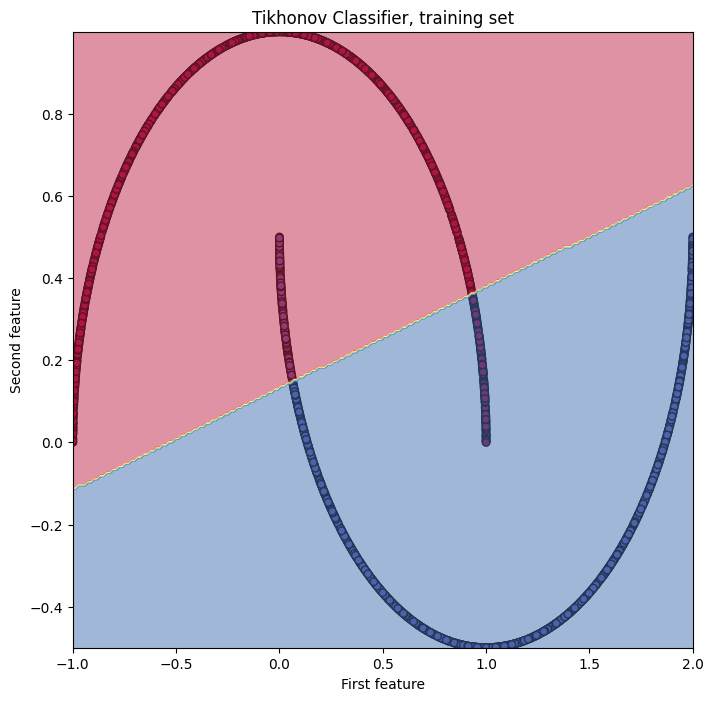

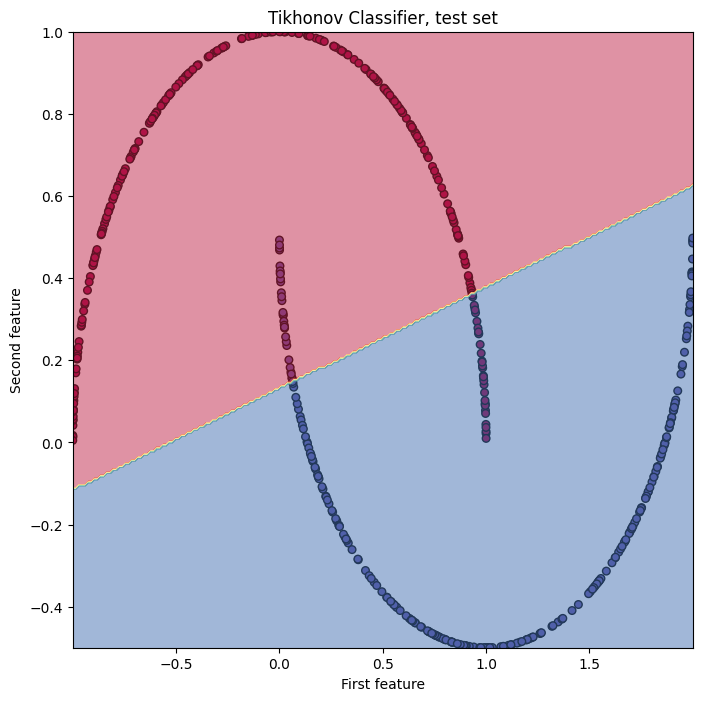

Accuracy: 0.88, Sensivity: 0.88, Specifity: 0.87


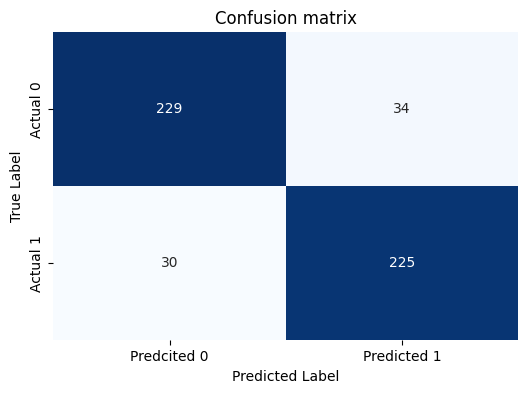

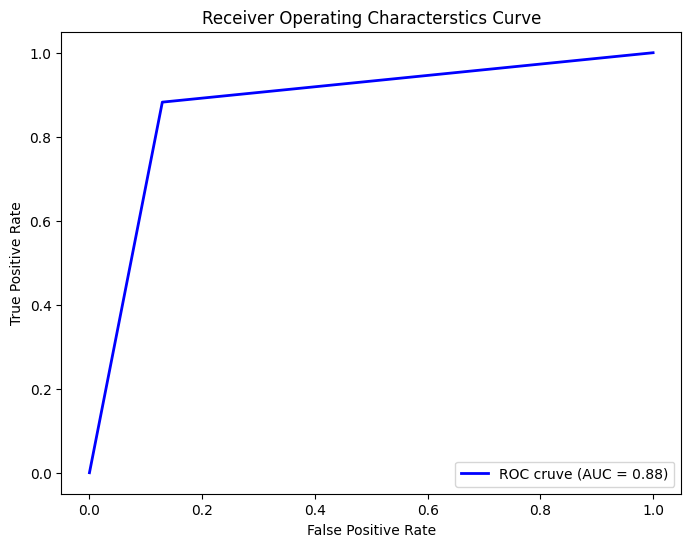

In [654]:
x, t = make_moons(n_samples=2587, random_state=254687) # x - generated samples, t - targets(etykiety) 0 or 1 for each samples
# Make moons return as 'x' array with shape (n_samples, 2), where 2 = n_features
t[t==0] = -1 # those that had a value '0' now have a  value '1'

# Spliting datasets into Training and test set
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(x, t, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train_moons = np.c_[np.ones((X_train_moons.shape[0], 1)), X_train_moons] # c_ is stacking arrays horizontally
X_test_moons = np.c_[np.ones((X_test_moons.shape[0], 1)), X_test_moons]

# Creating obcject, instance of class
classifier_own_moons = ClassifierAnalyticalTichonow() 

# Fit the classifier
classifier_own_moons.fit(X_train_moons, y_train_moons) 

# Making predictions
predictions_moons = classifier_own_moons.predict(X_test_moons) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train_moons[:,1], X_train_moons[:,2], c = y_train_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train_moons[:,1].min(), X_train_moons[:,1].max()
y_min, y_max = X_train_moons[:,2].min(), X_train_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier_own_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test_moons[:,1], X_test_moons[:,2], c = y_test_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test_moons[:,1].min(), X_test_moons[:,1].max()
y_min, y_max = X_test_moons[:,2].min(), X_test_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier_own_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test_moons, predictions_moons)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions_moons)

### 1.1.2. Dataset make classification

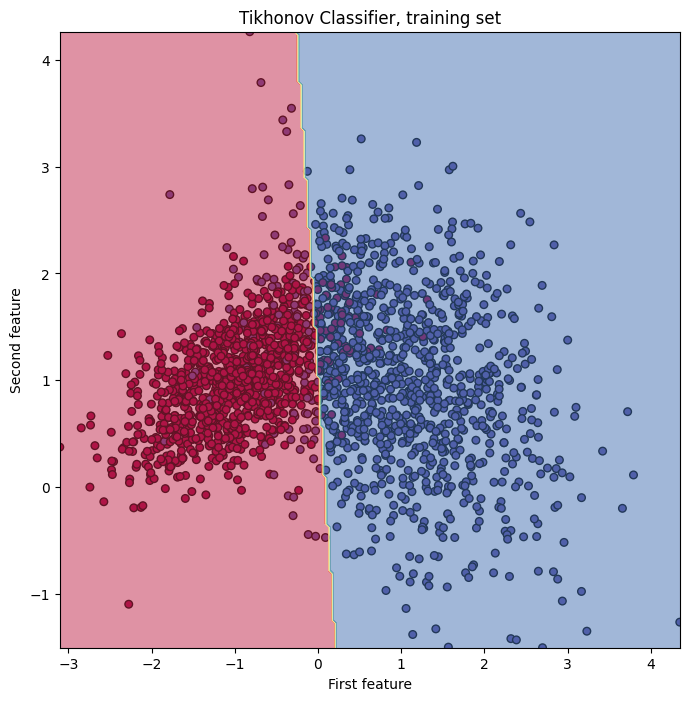

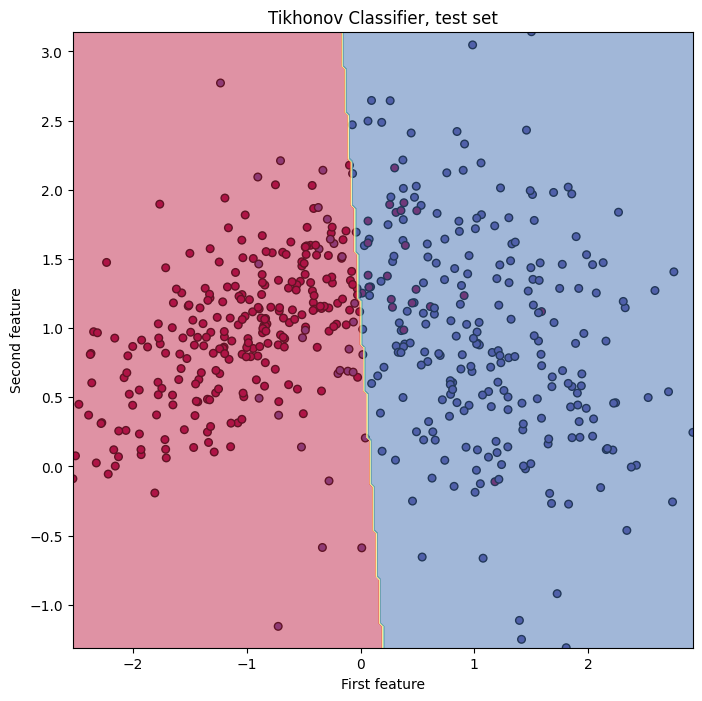

Accuracy: 0.90, Sensivity: 0.88, Specifity: 0.91


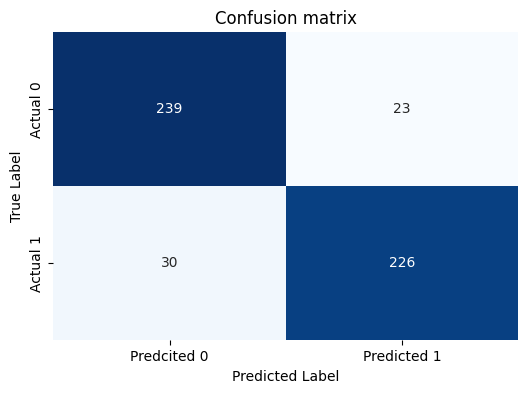

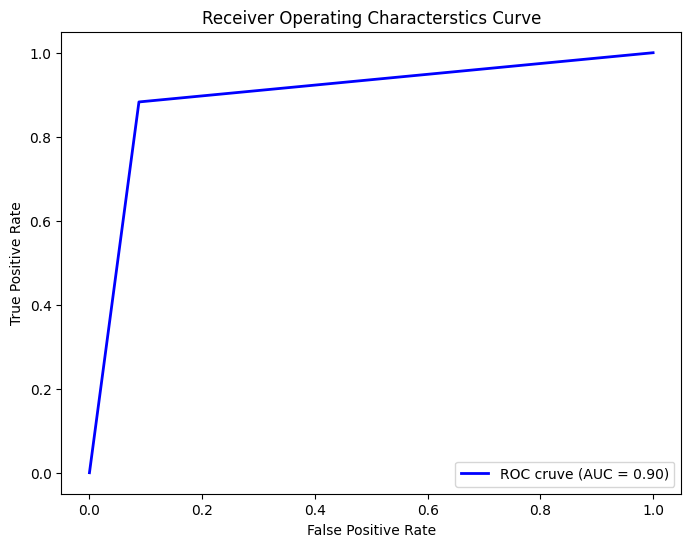

In [655]:
X, y = make_classification(n_samples=2587, n_features=2, n_informative=2, n_clusters_per_class=1, n_classes=2, n_redundant=0, random_state=254687)
y[y==0] = -1

# Spliting datasets into Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train] # c_ is stacking arrays horizontally
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Creating obcject, instance of class
classifier_own = ClassifierAnalyticalTichonow() 

# Fit the classifier
classifier_own.fit(X_train, y_train) 

# Making predictions
predictions = classifier_own.predict(X_test) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train[:,1], X_train[:,2], c = y_train, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train[:,1].min(), X_train[:,1].max()
y_min, y_max = X_train[:,2].min(), X_train[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier_own.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()


# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test[:,1].min(), X_test[:,1].max()
y_min, y_max = X_test[:,2].min(), X_test[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier_own.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

Widać że granica decyzyjna nie jest satysfakcjonująca, dlatego też można zbudować nieliniową powierzchnię decyzyjną, ale zachowując liniowosc w przestrzeni parametrów

In [656]:
# X = np.ones((x.shape[0], 6))
# X[:,0] = x[:,0]*x[:,0] # x1*x1 # Im using samples from make moons
# X[:,1] = x[:,1]*x[:,1] # x2*x2
# X[:,2] = x[:,0]*x[:,1] # x1*x2
# X[:,3] = x[:,0] # x1
# X[:,4] = x[:,1] # x2

# # calculating a vector of parameters
# Theta = np.linalg.inv(X.T@X)@X.T@t

# z = Theta[0]*xx*xx + Theta[1]*yy*yy + Theta[2]*xx*yy + Theta[3]*xx + Theta[4]*yy + Theta[5]

# plt.scatter(x[t==1,0], x[t==1,1])
# plt.scatter(x[t==-1,0],x[t==-1,1])
# plt.contour(xx,yy,z, levels=[0]) # levels=[0] means decision boudary


# 2. Sklearn Ridge Classifier
## 2.1. Training model on signle-mode datasets

### 2.1.1. Dataset make moons

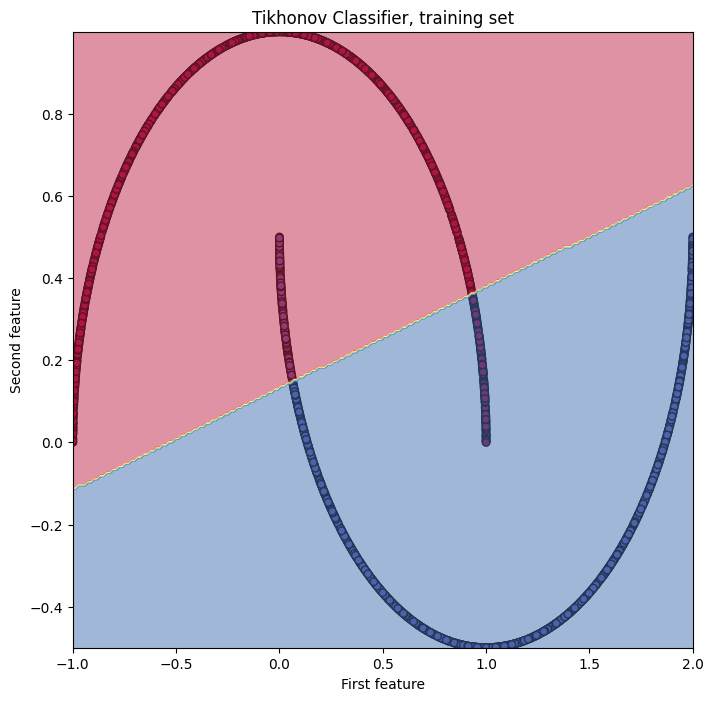

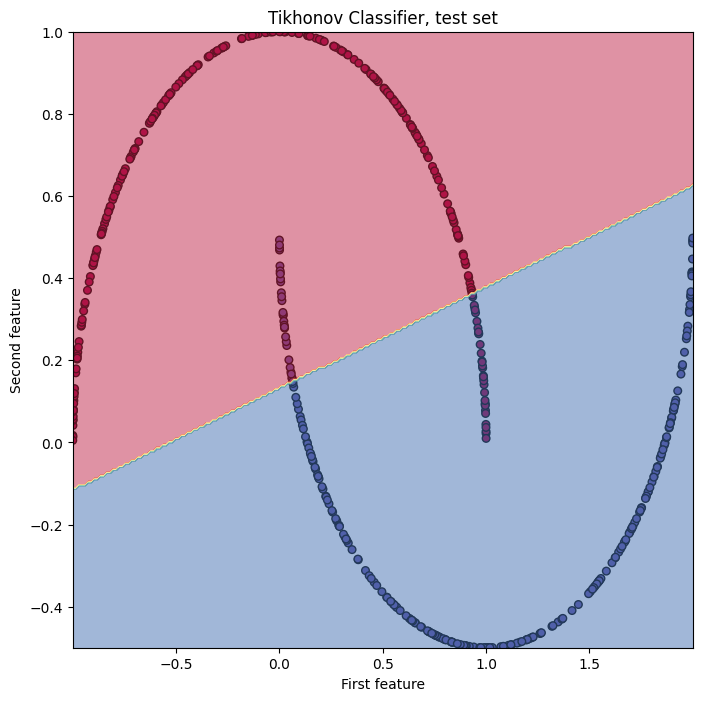

Accuracy: 0.88, Sensivity: 0.88, Specifity: 0.87


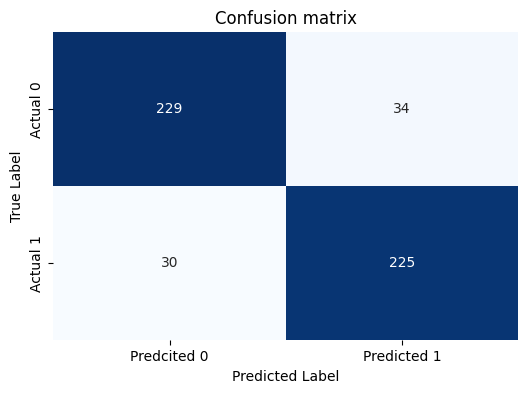

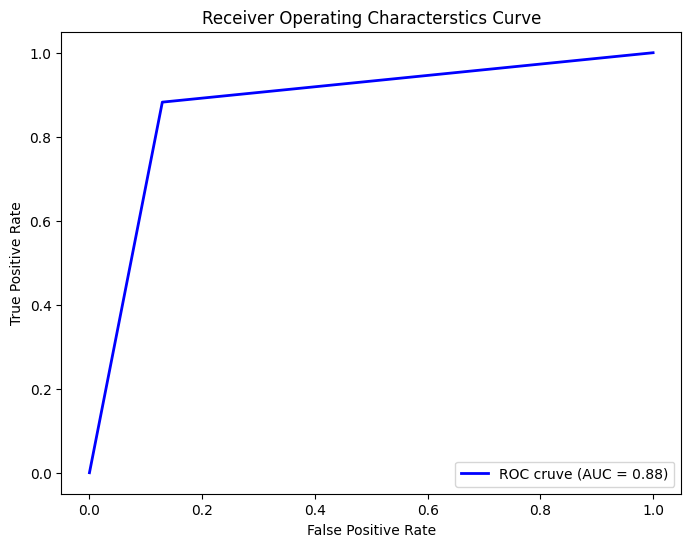

In [657]:
x, t = make_moons(n_samples=2587, random_state=254687) # x - generated samples, t - targets(etykiety) 0 or 1 for each samples
# Make moons return as 'x' array with shape (n_samples, 2), where 2 = n_features
t[t==0] = -1 # those that had a value '0' now have a  value '1'

# Spliting datasets into Training and test set
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(x, t, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train_moons = np.c_[np.ones((X_train_moons.shape[0], 1)), X_train_moons] # c_ is stacking arrays horizontally
X_test_moons = np.c_[np.ones((X_test_moons.shape[0], 1)), X_test_moons]

# Creating obcject, instance of class
classifier_moons = RidgeClassifier(alpha=0.1)

# Fit the classifier
classifier_moons.fit(X_train_moons, y_train_moons) 

# Making predictions
predictions_moons = classifier_moons.predict(X_test_moons) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train_moons[:,1], X_train_moons[:,2], c = y_train_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train_moons[:,1].min(), X_train_moons[:,1].max()
y_min, y_max = X_train_moons[:,2].min(), X_train_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test_moons[:,1], X_test_moons[:,2], c = y_test_moons, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test_moons[:,1].min(), X_test_moons[:,1].max()
y_min, y_max = X_test_moons[:,2].min(), X_test_moons[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier_moons.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test_moons, predictions_moons)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions_moons)

### 2.1.2. Dataset make classification

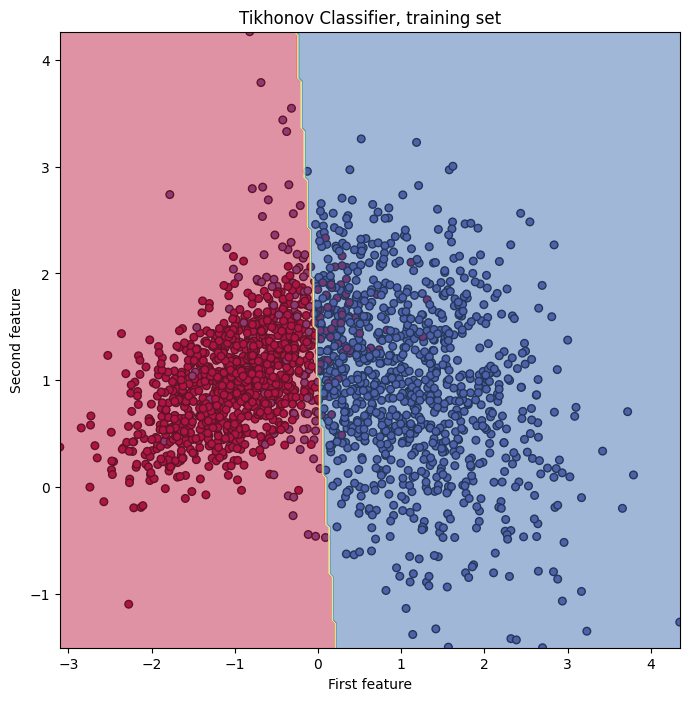

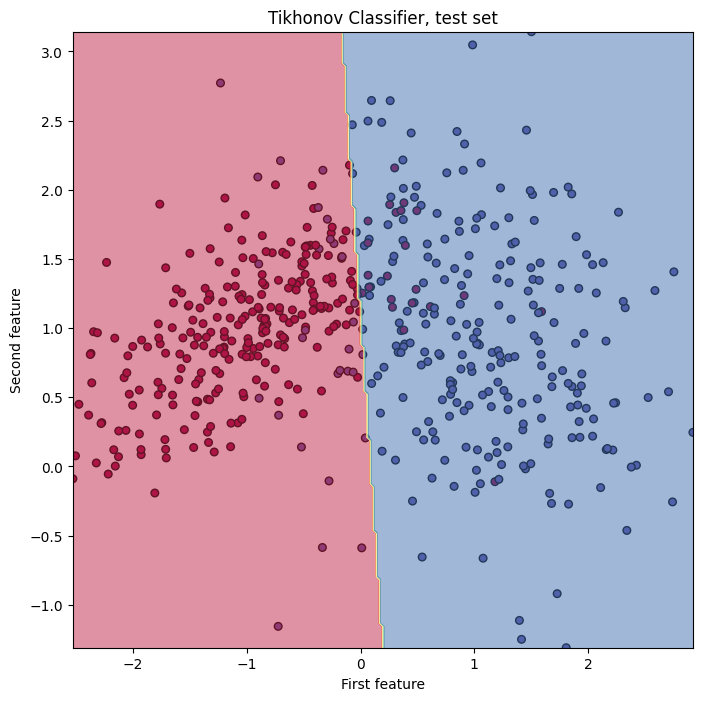

Accuracy: 0.90, Sensivity: 0.88, Specifity: 0.91


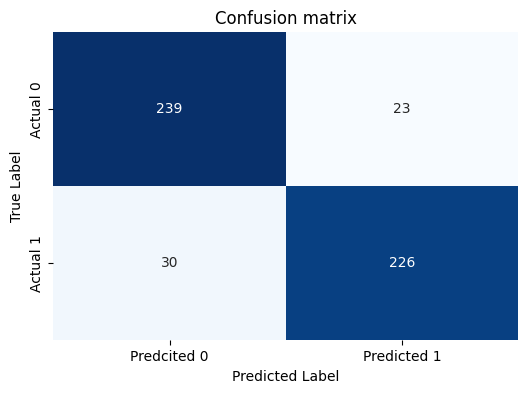

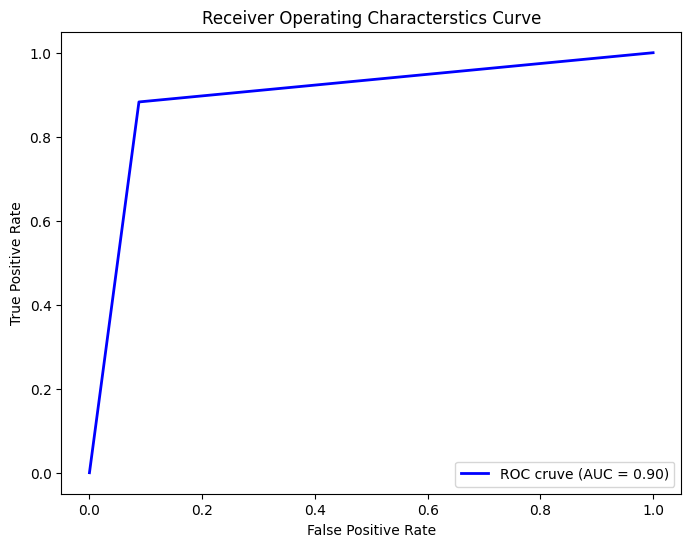

In [658]:
X, y = make_classification(n_samples=2587, n_features=2, n_informative=2, n_clusters_per_class=1, n_classes=2, n_redundant=0, random_state=254687)
y[y==0] = -1

# Spliting datasets into Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=254687)

# Adding a bias term 
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train] # c_ is stacking arrays horizontally
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Creating obcject, instance of class
classifier = RidgeClassifier() 

# Fit the classifier
classifier.fit(X_train, y_train) 

# Making predictions
predictions = classifier.predict(X_test) 

# Plot training dataset
plt.figure(figsize=(8,8))
plt.scatter(X_train[:,1], X_train[:,2], c = y_train, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, training set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_train[:,1].min(), X_train[:,1].max()
y_min, y_max = X_train[:,2].min(), X_train[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_train = classifier.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_train = Z_train.reshape(xx.shape) 

# plot the decision boundary for training dataset
plt.contourf(xx, yy, Z_train, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()


# Plot test dataset
plt.figure(figsize=(8,8))
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, cmap=plt.cm.Spectral, edgecolors='k', s=30) # X[:,1] start with '1' to skip the column with bias,
# 'c' sets the color of each point in the scatter accroding to the array 't', 
# 'cm.Spectral' is a colormap that provides a range of colors. It often transistions from red to blue to distinguish between different classess or clusters. 
# 'k' stands for black, so each point will have a black border, s= size of each point
plt.title("Tikhonov Classifier, test set")
plt.xlabel("First feature")
plt.ylabel("Second feature")

x_min, x_max = X_test[:,1].min(), X_test[:,1].max()
y_min, y_max = X_test[:,2].min(), X_test[:,2].max()

# linspace generates evenly spaced values between range so linspace returns vector with shape (200,)
# mashgrid creates a grid of coordinates and meshgrid returns array with shape (200, 200)
# why I need meshgrid? To represent all combinations of (x, y) coordinates in the plot area 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# ravel flattens the grid into 1d so 40,000 points 
Z_test = classifier.predict(np.c_[np.ones((xx.ravel().shape[0],1)), xx.ravel(), yy.ravel()])

# Back to a 2D grid so from 40.000 making 200x200
Z_test = Z_test.reshape(xx.shape) 

# plot the decision boundary for test dataset
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

**Conclusions** Both methods gave the same results.

# 3. Preprocessing of HeartCleveland

In [659]:
import pandas as pd

# Upload name of columns, 14 features
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
columns_without_target = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# na_values is used for interpreting NA (Not available) data as a missing values, not only empty cell is a missing value but also '?'
df = pd.read_csv('HeartCleveland.csv', names=columns, na_values="?")

# Counting NA samples
for column in columns:
    missing_values = df[column].isnull().sum()
    print(f"There is {missing_values} in the column {column}") 

# Deleting rows with NA
df = df.dropna()

# Print head
print(df.head())

# Changing target value to binary, from 0 (no presence):4 to -> -1:1
df['num'] = df['num'].apply(lambda x: -1 if x == 0 else 1)

# Separate features and target
X = df.drop('num', axis=1)
y = df['num']

# Using mean value for continious variables, discrete  and mode for categorical
continious_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
discrete_features = ['ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

There is 0 in the column age
There is 0 in the column sex
There is 0 in the column cp
There is 0 in the column trestbps
There is 0 in the column chol
There is 0 in the column fbs
There is 0 in the column restecg
There is 0 in the column thalach
There is 0 in the column exang
There is 0 in the column oldpeak
There is 0 in the column slope
There is 4 in the column ca
There is 2 in the column thal
There is 0 in the column num
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3 

## 3.1 Computing basic metrics 

In [660]:
# Computing mean value
for feature in continious_features:
    mean = df[feature].mean().__round__()
    print(f"Mean value for {feature} is: {mean}")

# Computing mode for cateogircal features
for feature in categorical_features:
    mode = df[feature].mode()[0]
    print(f"Mode value for {feature} is: {mode}")

# Computing median for discrete features
for feature in discrete_features:
    median = df[feature].median()
    print(f"Median value for {feature} is {median}")

Mean value for age is: 55
Mean value for trestbps is: 132
Mean value for chol is: 247
Mean value for thalach is: 150
Mean value for oldpeak is: 1
Mode value for sex is: 1.0
Mode value for cp is: 4.0
Mode value for fbs is: 0.0
Mode value for restecg is: 0.0
Mode value for exang is: 0.0
Mode value for slope is: 1.0
Mode value for thal is: 3.0
Median value for ca is 0.0


## 3.2 Histograms of features

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_histogram(df: pd.DataFrame, feature: str, is_categorical: bool, is_discrete: bool = False) -> None:
    """
    Plot a histogram or bar chart for a given feature in the dataset, 
    colored by the binary target class (coolumn 'num')

    Parameters:
    - df: pandas DataFrame with the data
    - feature: the name of the feature 
    - is_categorical: True if the feature is categorical
    - is_discrete: True if the feature is discrete 
    """

    plt.figure(figsize=(10,6))

    if is_categorical or is_discrete:
        # stacked bar for categorical or discrete features
        # crosstab is creating table in which it counts how many times each value of feature appears
        crosstab = pd.crosstab(df[feature], df['num']) # num is a target
        crosstab.plot(kind='bar', stacked=True, figsize=(10,6))
        legend_labels = {-1: "No disease", 1:"Disease"}
        
        plt.title(f"Distribution of {feature} by target")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.legend(title='Target', labels=[legend_labels.get(int(key), key) for key in crosstab.columns])
        plt.tight_layout()
        plt.show()

    else:
        # Histogram for continious features
        sns.histplot(
            data=df,
            x=feature,
            hue='num',
            multiple="stack",
        )
        plt.title(f"Distribution of {feature} by target")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.legend(labels=['Disease', 'No disease'])
        plt.tight_layout()
        plt.show()

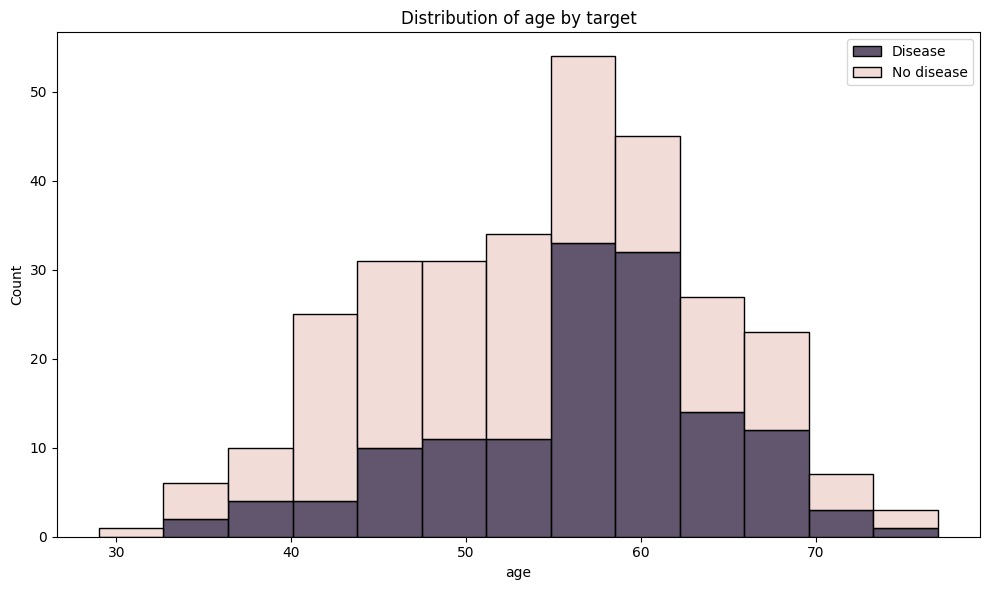

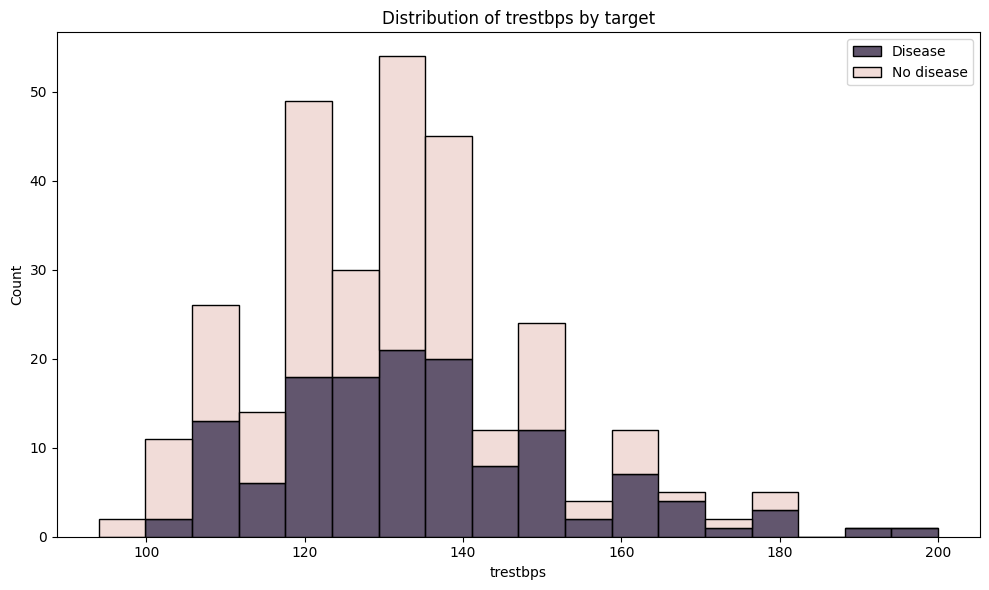

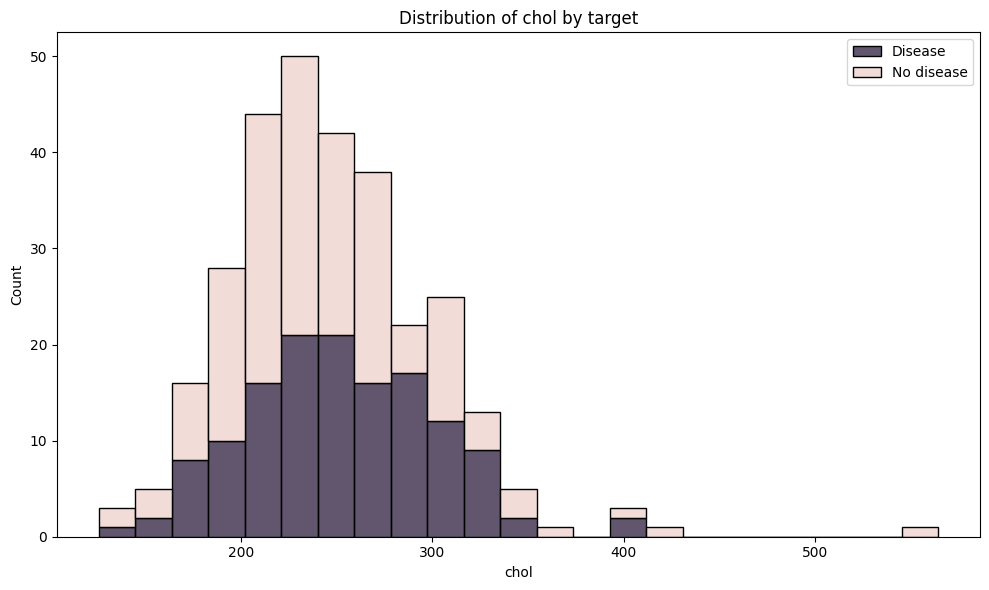

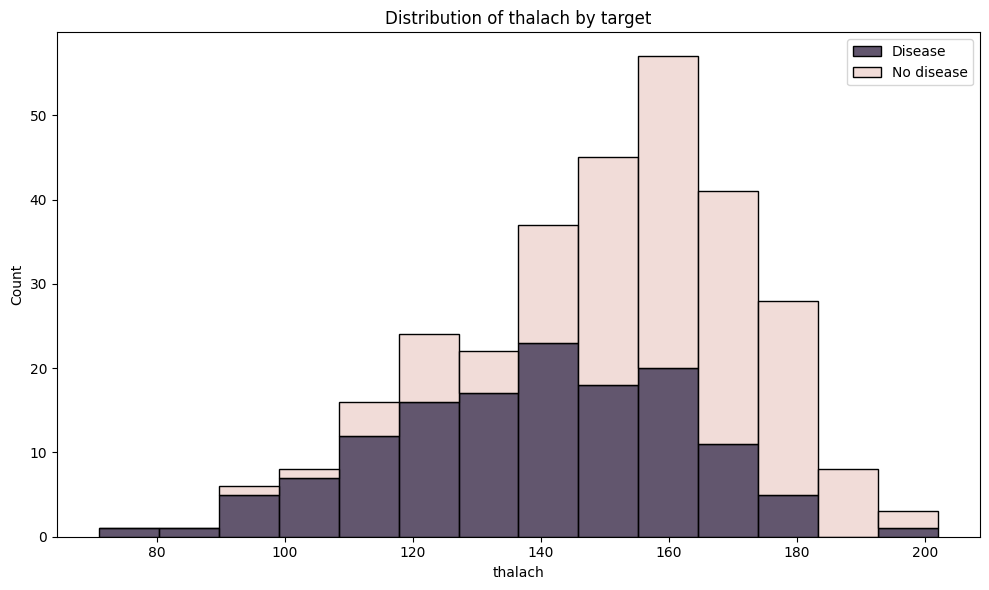

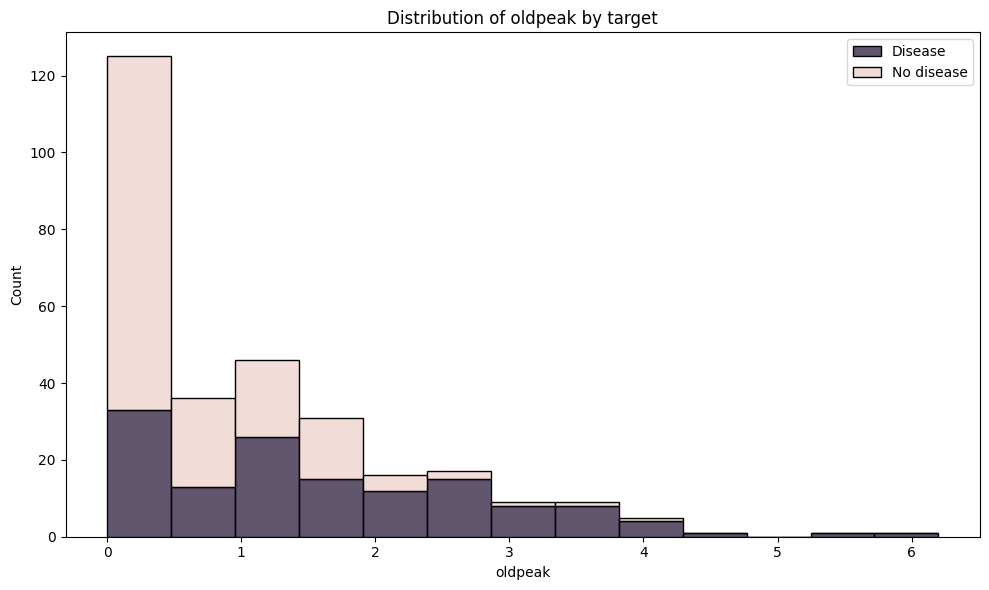

<Figure size 1000x600 with 0 Axes>

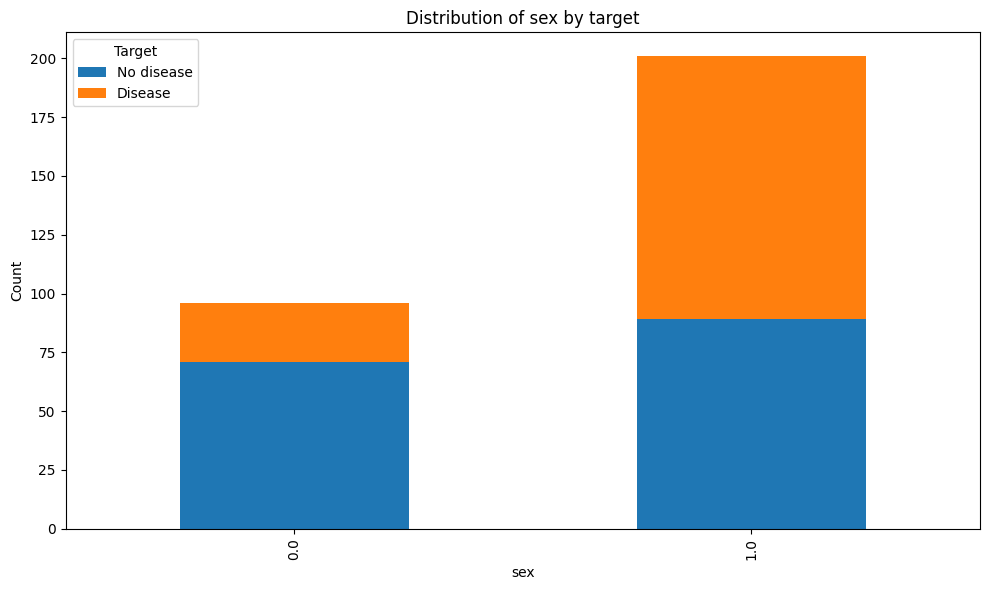

<Figure size 1000x600 with 0 Axes>

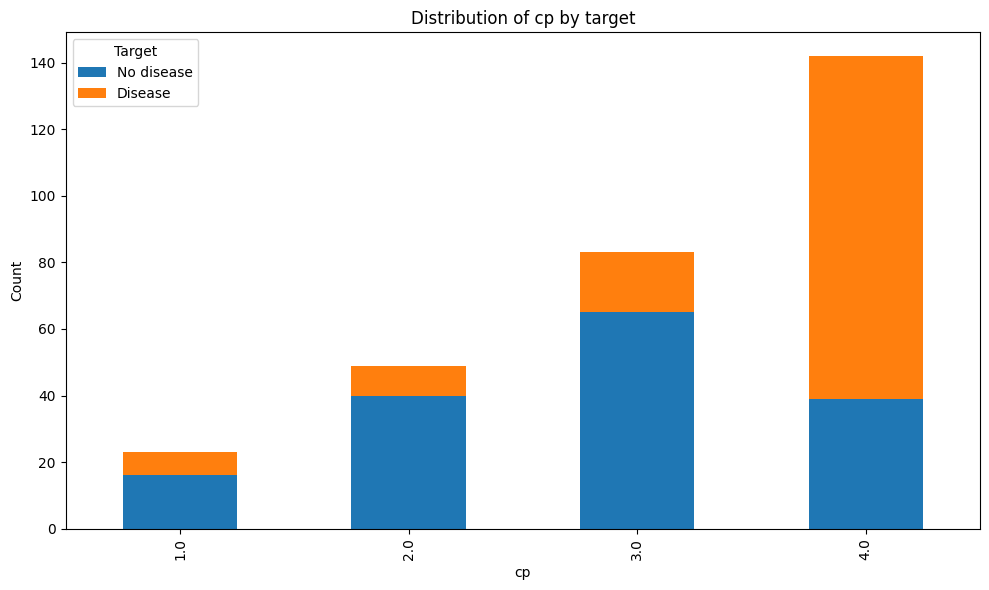

<Figure size 1000x600 with 0 Axes>

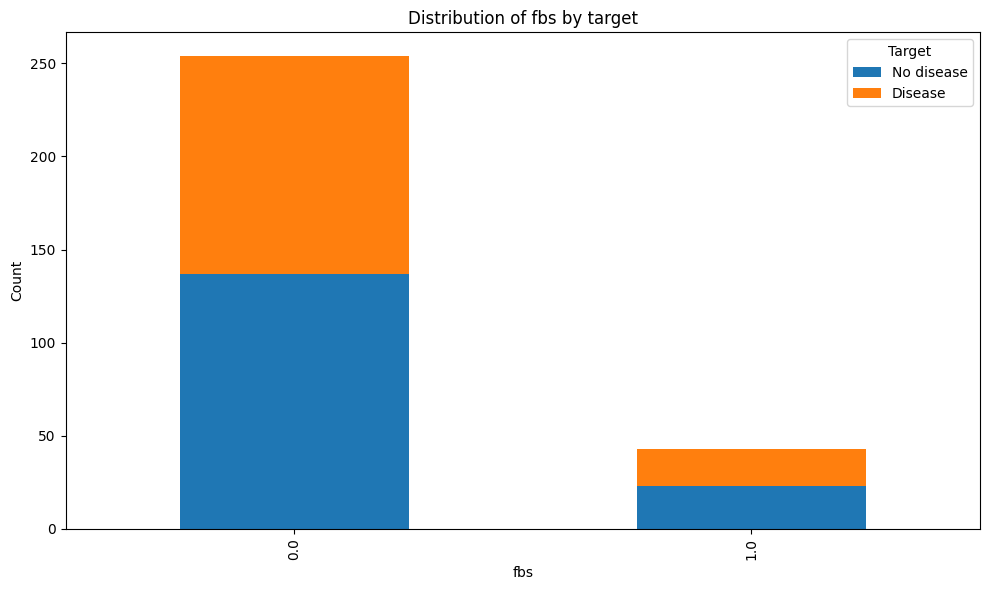

<Figure size 1000x600 with 0 Axes>

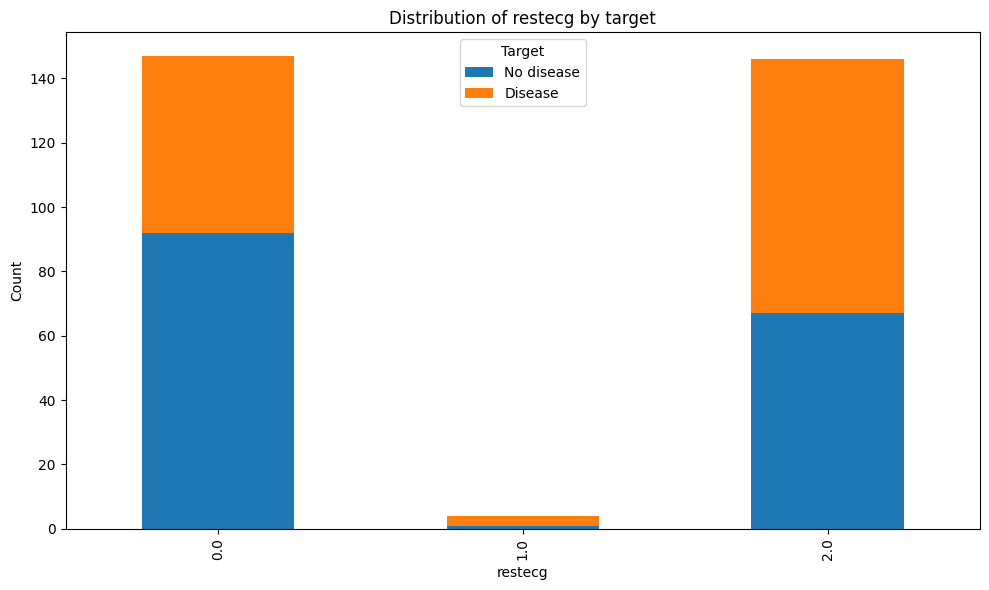

<Figure size 1000x600 with 0 Axes>

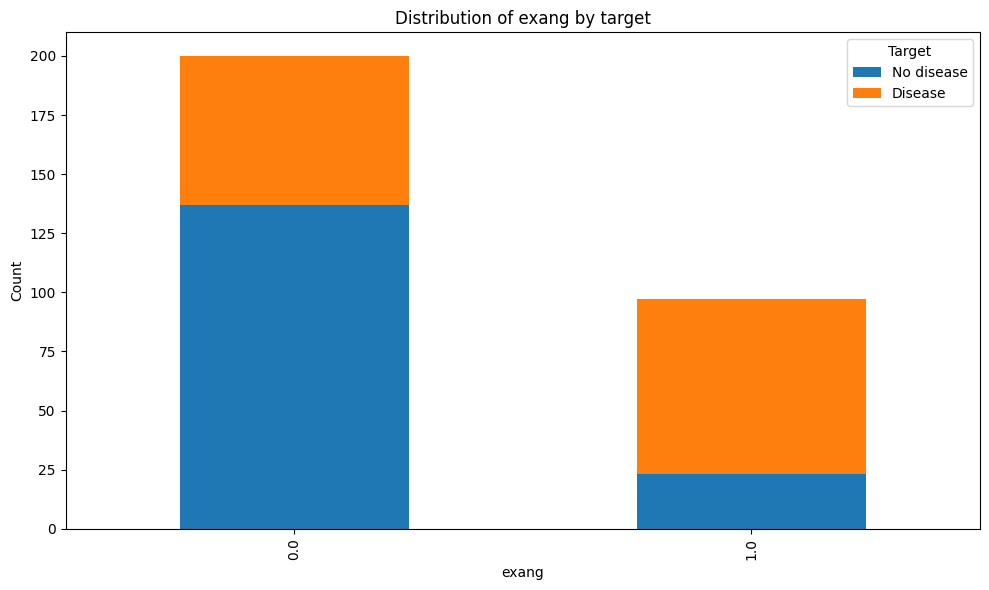

<Figure size 1000x600 with 0 Axes>

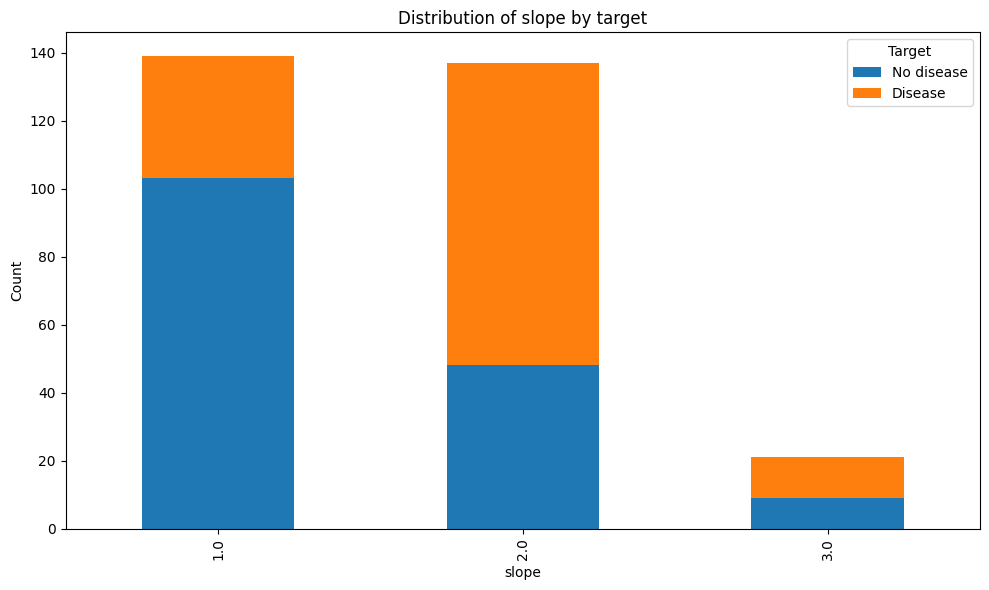

<Figure size 1000x600 with 0 Axes>

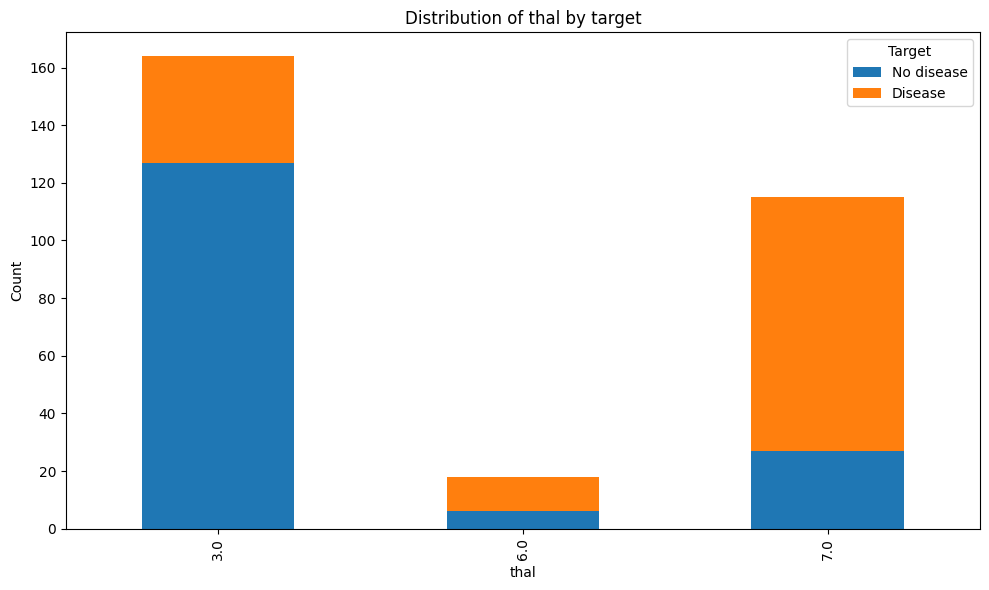

<Figure size 1000x600 with 0 Axes>

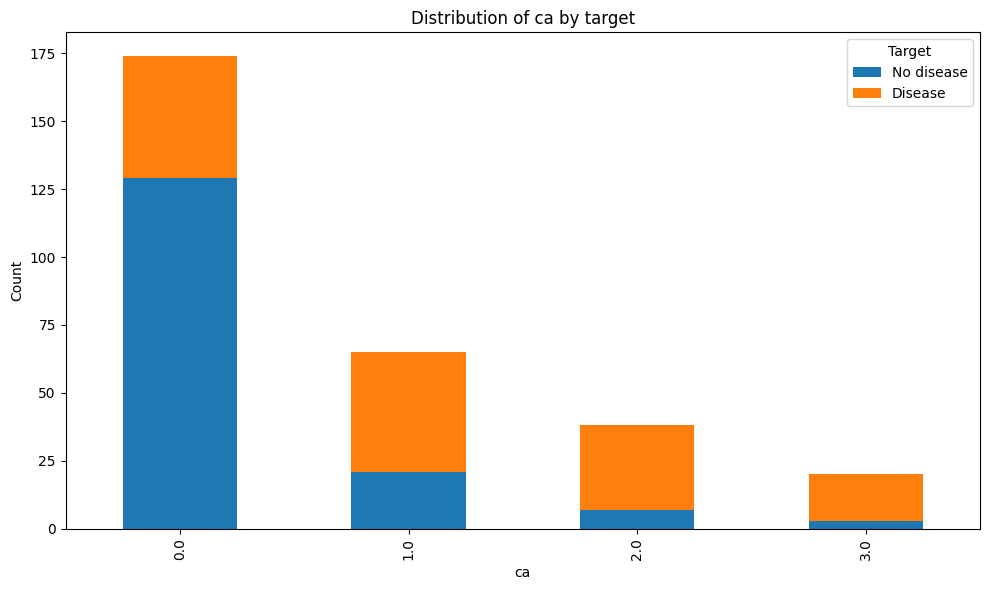

In [662]:
for feature in continious_features:

    plot_feature_histogram(df, feature, is_categorical=False)

for feature in categorical_features:

    plot_feature_histogram(df, feature, is_categorical=True)

plot_feature_histogram(df, 'ca', is_categorical=False, is_discrete=True)

## 3.3 Correlation matrix 

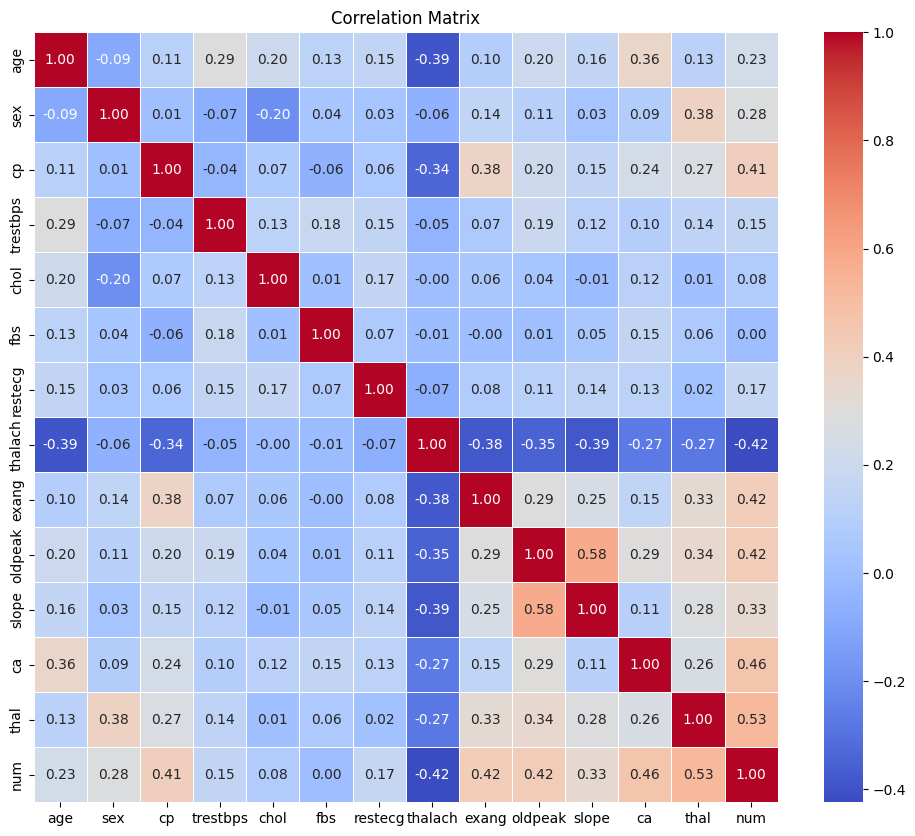

In [663]:
# Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


### 3.3.1. Choosing best 4 features manually

The strongest correlation with target 'num' has a feature 'thal' 0,53, second one is 'ca' with result 0,46. Now I am checking if 'thal' is correlated with 'ca' and it has 0,26 so not so strong. Oldpeak and exang have 0,42 correlation with num, but oldpeak has a stronger correlation with ca and thal, thats why better is exang. Now let's consider thalach and cp. Cp is less correlated with ca than thalach 
1. thal
2. ca
3. exang
4. cp

# 4. Checking implementation on HeartCleveland

## 4.1 RidgeClassifier

Accuracy: 0.82, Sensivity: 0.68, Specifity: 0.91


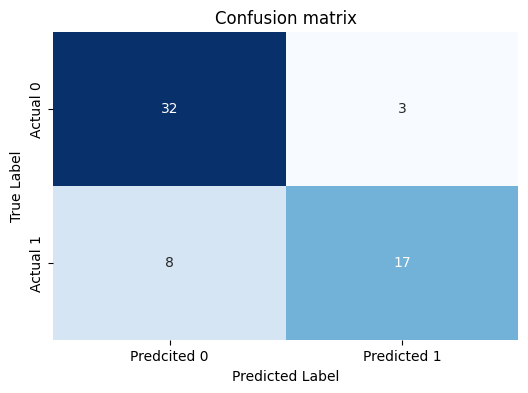

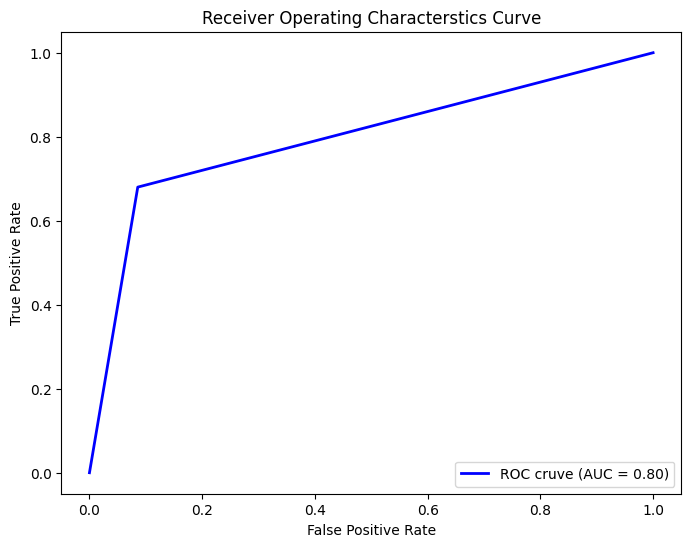

In [664]:
from sklearn.preprocessing import StandardScaler

# Spliting datasets into Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=254687)

# Normalize 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Adding a bias term 
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train] # c_ is stacking arrays horizontally
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Creating obcject, instance of class
classifier = RidgeClassifier() 

# Fit the classifier
classifier.fit(X_train, y_train) 

# Making predictions
predictions = classifier.predict(X_test) 

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

## 4.2 Own implementation classifier with Tichonov regularization

Accuracy: 0.82, Sensivity: 0.68, Specifity: 0.91


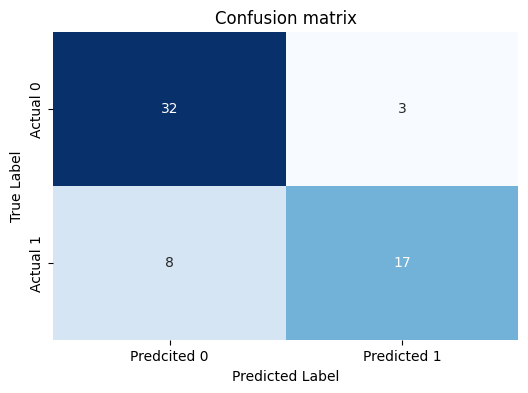

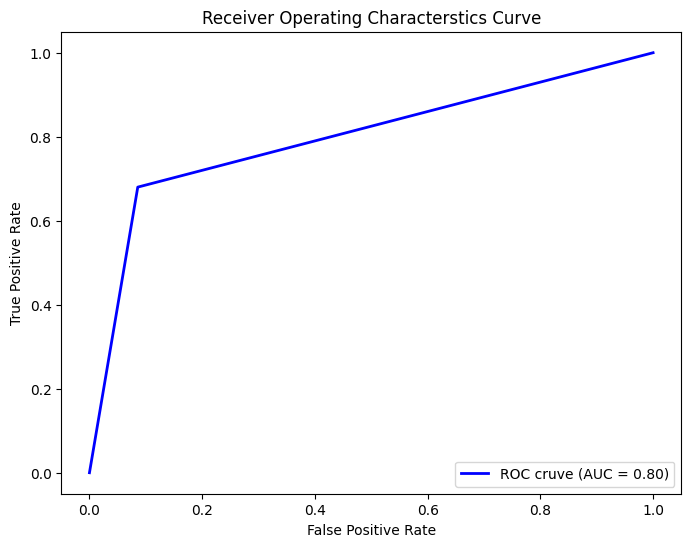

In [665]:
# Creating obcject, instance of class
classifier_own = ClassifierAnalyticalTichonow() 

# Fit the classifier
classifier_own.fit(X_train, y_train) 

# Making predictions
predictions = classifier_own.predict(X_test) 

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

## 4.3 Choosing best 4 features automatically

In [666]:
from sklearn.feature_selection import SequentialFeatureSelector

# Creating obcject, instance of class
classifier_with_selelcting_features = RidgeClassifier() 

# Feature Selector demands not fitted estimator 
sfs = SequentialFeatureSelector(classifier_with_selelcting_features, n_features_to_select=4)
sfs.fit(X_train, y_train)
feature_names = df.drop(columns=['num']).columns.tolist()
selected_indices = sfs.get_support(indices=True) # get support returns integer index of selected features
selected_features = [feature_names[i] for i in selected_indices-1] # -1 Beucase of bias term in first column of the X_train

**Conclusion** The same features were chosen

## 4.4 Results of estimator based on 4 features

### 4.4.1. RidgeClassifier

Accuracy: 0.83, Sensivity: 0.68, Specifity: 0.94


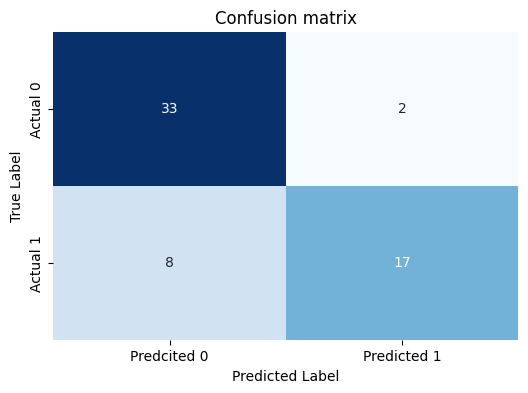

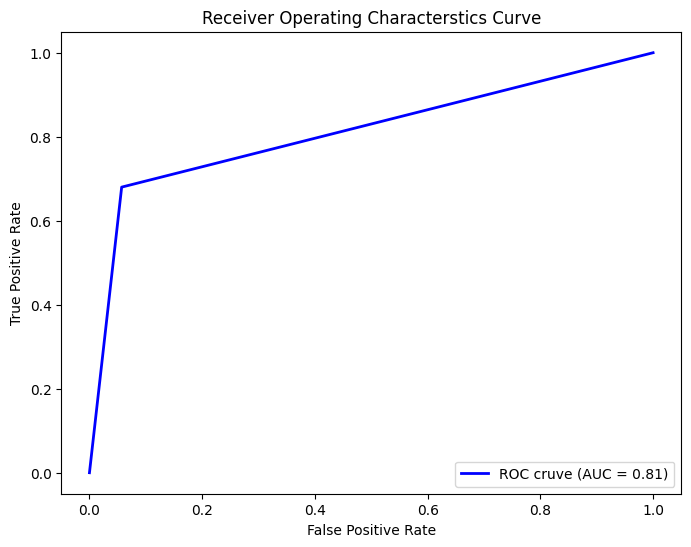

In [667]:
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

# Creating obcject, instance of class
classifier_selected_features = RidgeClassifier() 

# Fit the classifier
classifier_selected_features.fit(X_train_selected, y_train) 

# Making predictions
predictions = classifier_selected_features.predict(X_test_selected) 

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

### 4.4.2. Own implementation classifier with Tichonov regularization

Accuracy: 0.82, Sensivity: 0.68, Specifity: 0.91


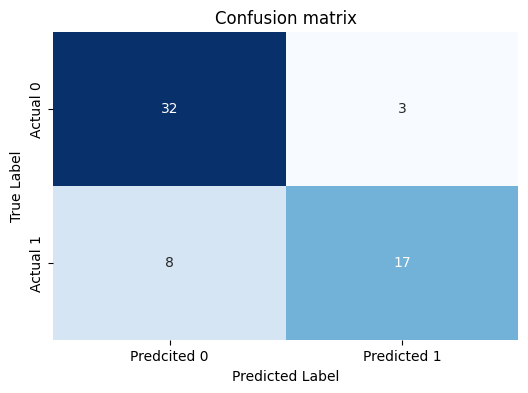

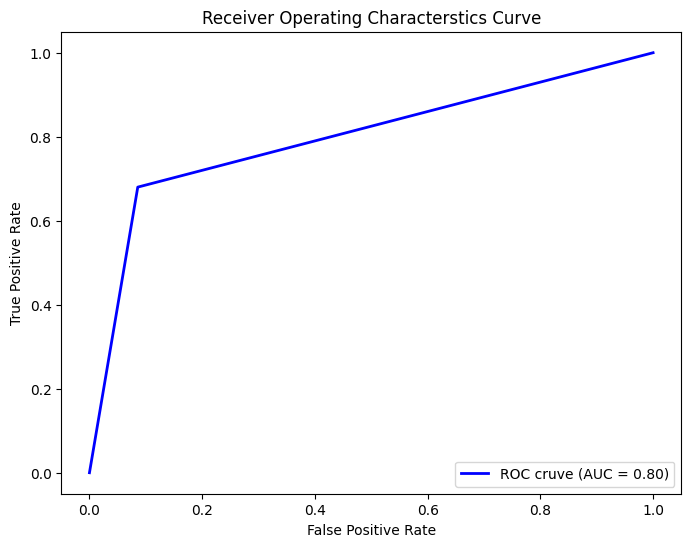

In [668]:
# Creating obcject, instance of class
classifier_own_selected_features = ClassifierAnalyticalTichonow() 

# Fit the classifier
classifier_own_selected_features.fit(X_train_selected, y_train) 

# Making predictions
predictions = classifier_own_selected_features.predict(X_test_selected) 

results = ResultsAnalyzes(y_test, predictions)
results.show_results()
results.confusion_matrix()
results.plot_ROC_curve(predictions)

**Conclusions** Own implementation has worse results for model with choosing features